In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import pandas as pd
import rasterio.plot

import overpy
import geopandas as gpd
# import ee
from shapely.geometry import Polygon, box
import os
import geemap
import json
import multiprocessing



In [6]:
os.chdir('/Users/yj/Downloads/')

In [7]:
api = overpy.Overpass()

In [8]:

# Fetch all wastewater treatment plants within California's boundary
query = f"""
    area[admin_level=4]["name"="California"]->.searchArea;
    (
    way["man_made"="wastewater_plant"](area.searchArea);
    );
    (._;>;);
    out body;
    """

result = api.query(query)

plants = {}

for way in result.ways:
    # Use the name of the plant or its ID if the name is not available
    plant_name = way.tags.get("name", f"Plant_{way.id}")

    # Extract nodes lat and lon without id
    nodes_coords = [(node.lon, node.lat) for node in way.nodes]

    # get rid of "Decimal"  in the coordinates
    nodes_coords = [tuple(map(float, i)) for i in nodes_coords]
    
    plants[plant_name] = nodes_coords

# plants_with_official_name = {key: value for key, value in plants.items() if not key.startswith("Plant_")}


geoms = [Polygon(plants[key]) for key in plants]
df = gpd.GeoDataFrame({'WWTP_name': list(plants.keys()), 'geometry': geoms}, crs="EPSG:4326")
df["centroid"] = df.to_crs('+proj=cea').centroid.to_crs(epsg=4326)



In [9]:
df

,WWTP_name,geometry,centroid
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6...",POINT (-121.80762 37.69120)
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8...",POINT (-121.78025 36.79990)
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8...",POINT (-122.29525 37.82512)
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9...",POINT (-118.43006 33.92574)
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4...",POINT (-121.94663 37.43156)
...,...,...,...
3101,Plant_1188491467,"POLYGON ((-121.52373 38.56623, -121.52238 38.5...",POINT (-121.52255 38.56391)
3102,Plant_1201733978,"POLYGON ((-118.94698 37.64148, -118.94744 37.6...",POINT (-118.94450 37.63989)
3103,Plant_1205552620,"POLYGON ((-121.96382 38.68125, -121.96450 38.6...",POINT (-121.96297 38.67961)
3104,Plant_1213883271,"POLYGON ((-120.46290 38.12344, -120.46263 38.1...",POINT (-120.46110 38.12511)


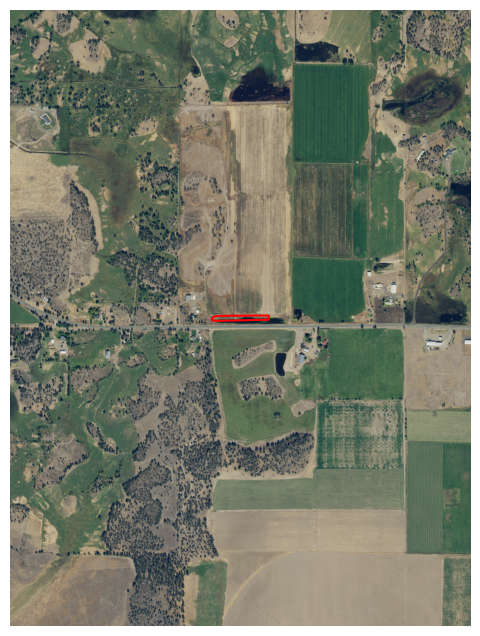

In [13]:
# use loop to open the image in downloaded_images_2, and plot the bounding box on it
# read all the file name in the downloaded_images_2
for file in os.listdir('wwtp_images 12'):
    try:
        with rasterio.open(os.path.join('wwtp_images 12', file)) as src:
            if file.startswith('download'):
                continue
            # Read the image data
            img = src.read([1, 2, 3])  # Reads the first three bands for RGB
            # file name without extension
            name = os.path.splitext(file)[0]
            # find the corresponding bounding box
            df_name = df.loc[df['WWTP_name'] == name, :]
            # plot the bounding box
            fig, ax = plt.subplots(figsize=(8,8))
            # Plot the raster
            ax = rasterio.plot.show(img, ax=ax, transform=src.transform)
            # Plot the geometry on the ax axes instance
            df_name.boundary.plot(ax=ax, color='red', linewidth=1.5)
            plt.axis('off')
            # save the figure
            plt.savefig(os.path.join('wwtp_images 12', name + '.png'), bbox_inches='tight', pad_inches=0)
            plt.close()
    except:
        print(f"fail to plot {file}")